In [1]:
from tensorflow import keras
import tensorflow_datasets.public_api as tfds
import tensorflow as tf
import pathlib

Создаём датасет с цветочками

In [2]:
data_dir = tf.keras.utils.get_file(origin="C:\\Users\\samki\\Downloads\\flowers.zip",
                                   fname="flower_photos",
                                   untar=True)
data_dir = pathlib.Path(data_dir)

# Константы
batch_size = 20
img_height = img_width = 180

# Разбиваем датасет на тренировочную группу и группу валидации
train_data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    image_size=(img_height, img_width),
    batch_size=batch_size,
    seed=5432,
)

validation_data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    image_size=(img_height, img_width),
    batch_size=batch_size,
    seed=5432,
)

# Нормализуем в [0; 1], + убираем лейблы (т.к. у нас задача не распознавать изображения)
train_data = train_data.map(lambda x, y: (x / 255.0, x / 255.0))
validation_data = validation_data.map(lambda x, y: (x / 255.0, x / 255.0))

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


Модель

In [17]:
from keras.layers import (Input, Dense, Conv2D, Conv2DTranspose, BatchNormalization,
                          Dropout, Flatten, Reshape, Lambda, MaxPool2D, Concatenate)
from keras.models import Model
from keras.losses import binary_crossentropy
from keras.layers import LeakyReLU
from keras.optimizers import RMSprop, Adam
from keras import backend as K
from keras.engine.keras_tensor import KerasTensor

# Константы
latent_dim = 16
dropout = 0.1

# Энкодер
input_img = Input(shape=(img_height, img_width, 3))

x = Conv2D(latent_dim*10, (3, 3), activation="relu")(input_img)
x = Dropout(dropout)(BatchNormalization()(x))
x = MaxPool2D((2, 2))(x)

x = Conv2D(latent_dim*8, (3, 3), activation="relu")(x)
x = Dropout(dropout)(BatchNormalization()(x))
x = MaxPool2D((2, 2))(x)

x = Conv2D(latent_dim*6, (3, 3), activation="relu")(x)
x = Dropout(dropout)(BatchNormalization()(x))
x = MaxPool2D((2, 2))(x)

x = Conv2D(latent_dim*4, (3, 3), activation="relu")(x)
x = Dropout(dropout)(BatchNormalization()(x))
x = MaxPool2D((2, 2))(x)

x = Conv2D(latent_dim*2, (3, 3), activation="relu")(x)
x = Dropout(dropout)(BatchNormalization()(x))
x = MaxPool2D((2, 2))(x)

x = Flatten()(x)

# Специальные промежуточные слои
z_mean = Dense(latent_dim, activation="sigmoid")(x)
z_log_var = Dense(latent_dim, activation="sigmoid")(x)

# Сэмплирование из Q с трюком репараметризации (что бы это не значило)
@tf.function
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=(latent_dim, ))  # Генерим нормальный шум
    return z_mean + tf.exp(z_log_var / 2) * epsilon   # Что-то возвращаем

# l ═ новый кастомный слой
l = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# Создаём энкодер
encoder = Model(input_img, l, "encoder")

# Декодер
z = Input(shape=(latent_dim, ))

x = Dense(latent_dim)(z)
x = LeakyReLU()(x)
x = Dropout(dropout)(BatchNormalization()(x))

x = Dense(latent_dim*2)(x)
x = LeakyReLU()(x)
x = Dropout(dropout)(BatchNormalization()(x))

x = Dense(latent_dim*4)(x)
x = LeakyReLU()(x)
x = Dropout(dropout)(BatchNormalization()(x))

x = Dense(latent_dim*6)(x)
x = LeakyReLU()(x)
x = Dropout(dropout)(BatchNormalization()(x))

x = Dense(latent_dim*8)(x)
x = LeakyReLU()(x)
x = Dropout(dropout)(BatchNormalization()(x))

x = Dense(latent_dim)(x)
x = LeakyReLU()(x)
x = Dropout(dropout)(BatchNormalization()(x))

x = Dense(img_width * img_height * 3, activation="sigmoid")(x)
output_img = Reshape((img_height, img_width, 3))(x)

decoder = Model(z, output_img, name="decoder")

# VAE модель
vae = Model(input_img, decoder(l), name="vae")

# Создаём свою функцию ошибки (спиздил с инета)
@tf.function
def vae_loss(x, decoded):
    # Что-то делаем
    x = K.reshape(x, shape=(batch_size, img_width * img_height * 3))
    decoded = K.reshape(decoded, shape=(batch_size, img_width * img_height * 3))

    # Мутим какую-то муть
    xent_loss = img_width * img_height * 3 * binary_crossentropy(x, decoded)
    kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)

    # Что-то там вычисляем
    loss = (xent_loss + kl_loss) / (2 * img_width * img_height * 3)

    # Возвращаем тензор
    return tf.keras.backend.constant(tf.float32, shape=(batch_size, img_width * img_height * 3), dtype=tf.float32)


vae.compile(optimizer="adam", loss="binary_crossentropy")
vae.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 97200), dtype=tf.float32, name=None), name='dense_89/Sigmoid:0', description="created by layer 'dense_89'")
Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_27 (InputLayer)          [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_65 (Conv2D)             (None, 178, 178, 16  4480        ['input_27[0][0]']               
                                0)                                                                
                                                                                                  
 batch_normalization_107 (Batch  (None, 1

In [18]:
vae.fit(
    train_data,
    epochs=20,
    validation_data=validation_data,
)

Epoch 1/20
147/147 [==============================] - 45s 290ms/step - loss: 0.6634 - val_loss: 0.7322
Epoch 2/20
147/147 [==============================] - 42s 287ms/step - loss: 0.6298 - val_loss: 0.7028
Epoch 3/20
147/147 [==============================] - 42s 287ms/step - loss: 0.6167 - val_loss: 0.7003
Epoch 4/20
147/147 [==============================] - 42s 286ms/step - loss: 0.6093 - val_loss: 0.7219
Epoch 5/20
147/147 [==============================] - 42s 287ms/step - loss: 0.6059 - val_loss: 0.7702
Epoch 6/20
147/147 [==============================] - 42s 287ms/step - loss: 0.6041 - val_loss: 0.8329
Epoch 7/20
147/147 [==============================] - 42s 287ms/step - loss: 0.6026 - val_loss: 0.7506
Epoch 8/20
147/147 [==============================] - 42s 287ms/step - loss: 0.6002 - val_loss: 0.7609
Epoch 9/20
147/147 [==============================] - 42s 286ms/step - loss: 0.5987 - val_loss: 0.7981
Epoch 10/20
147/147 [==============================] - 42s 287ms/step - l

KeyboardInterrupt: 

37/37 [==============================] - 2s 60ms/step


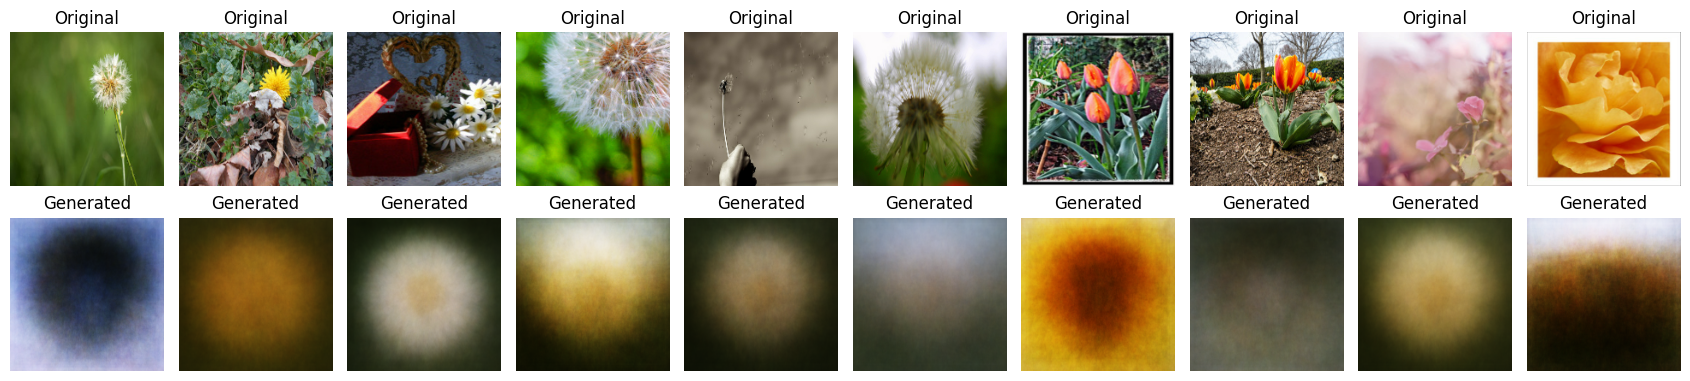

In [19]:
import matplotlib.pyplot as plt
from random import randint

# Генерация изображений с помощью автоэнкодера
generated_images = vae.predict(validation_data)
num_images = 10

# Конвертируем в список
validation_img = generated_img = []
for img, _ in validation_data:
    validation_img.extend(img.numpy())

# Отображение сгенерированных изображений
plt.figure(figsize=(17, 4))
for i in range(num_images):
    random_num = randint(0, len(validation_img))
    # Исходное изображение
    plt.subplot(2, num_images, i + 1)
    plt.imshow(validation_img[random_num])
    plt.title("Original")
    plt.axis("off")

    # Сгенерированное изображение
    plt.subplot(2, num_images, i + num_images + 1)
    plt.imshow(generated_images[random_num])
    plt.title("Generated")
    plt.axis("off")

plt.tight_layout()
plt.show()